In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
from transformers import AutoModel, AutoModelForImageClassification, AutoImageProcessor, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, get_cosine_schedule_with_warmup
import torchaudio

from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

import random
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/andy/anaconda3/envs/birdclef2025/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
class BirdTrainDatasetPrecomputed(Dataset):
    def __init__(self, data_df, data_path='data/precomputed_spectrograms/spectrograms', use_cutmix=True, use_masking=True):
        self.df = data_df
        self.path = data_path
        self.use_cutmix = use_cutmix
        self.use_masking = use_masking

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['file_path']
        label = self.df.iloc[idx]['label']
        spec = torch.load(path)

        if self.use_cutmix and random.random() < 0.5:
            # Horizontal CutMix
            mix_idx = random.randint(0, len(self.df) - 1)
            if mix_idx != idx:
                mix_path = self.df.iloc[mix_idx]['file_path']
                mix_label = self.df.iloc[mix_idx]['label']
                mix_spec = torch.load(mix_path)
                
                spec, label = self.horizontal_cutmix(spec, label, mix_spec, mix_label)

        if self.use_masking:
            spec = self.xy_masking(spec)

        return {
            "pixel_values": spec,
            "labels": torch.tensor(label, dtype=torch.long),
            "file_name": path,
        }

    def xy_masking(self, spec, num_masks=2, max_width=20, max_height=10):
        """
        Applies rectangular zero-masks to the spectrogram.
        """
        cloned = spec.clone()
        _, height, width = cloned.shape

        for _ in range(num_masks):
            w = random.randint(0, max_width)
            h = random.randint(0, max_height)
            x = random.randint(0, width - w) if width - w > 0 else 0
            y = random.randint(0, height - h) if height - h > 0 else 0
            cloned[:, y:y+h, x:x+w] = 0.0
        return cloned

    def horizontal_cutmix(self, spec1, label1, spec2, label2, alpha=1.0):
        """
        Mix two spectrograms horizontally (time axis).
        Returns mixed spec and averaged labels (for multi-label or soft targets).
        """
        _, h, w = spec1.shape
        cut_point = random.randint(int(0.3 * w), int(0.7 * w))
        lam = cut_point / w  # how much of spec1 remains

        new_spec = torch.cat((spec1[:, :, :cut_point], spec2[:, :, cut_point:]), dim=2)

        # Convert labels to float for soft blending
        label1 = torch.tensor(label1, dtype=torch.float)
        label2 = torch.tensor(label2, dtype=torch.float)

        mixed_label = lam * label1 + (1 - lam) * label2

        return new_spec, mixed_label
  
def get_datasets(df):
    """
    divides by original files instead of snippet files to avoid data leakage
    """

    # make new dataframe with just index and labels. remove all duplcates
    df_copy = df.copy()                 # Duplicate the DataFrame
    df_copy = df_copy.drop('file_path', axis=1)  # Drop the 'file_path' column
    df_copy = df_copy.drop_duplicates()          # Remove duplicate rows

    # Split data into train and validation sets
    train_df_idx, val_df_idx = train_test_split(
      df_copy, 
      test_size=0.2, 
      random_state=42, 
      stratify=df_copy['label']
    )

    # create dfs containing segmented audio from partitioned files
    train_df = df[df['file_num'].isin(train_df_idx['file_num'])]
    val_df = df[df['file_num'].isin(val_df_idx['file_num'])]

    train_ds = BirdTrainDatasetPrecomputed(train_df)
    val_ds = BirdTrainDatasetPrecomputed(val_df, use_cutmix=False, use_masking=False)
    return train_ds, val_ds

df = pd.read_csv('/home/andy/Desktop/BirdClef/customSED/data/precomputed_spectrograms/labels.csv')
ds_train, ds_val = get_datasets(df)
print("train_loader", len(ds_train))
print("val_loader", len(ds_val))
print("num_classes", df['label'].max()+1)

train_loader 119620
val_loader 29285
num_classes 206


Filepath: data/precomputed_spectrograms/spectrograms/10896_3600000.pt
Target: 113
Shape of mel spectrogram: torch.Size([3, 128, 641])


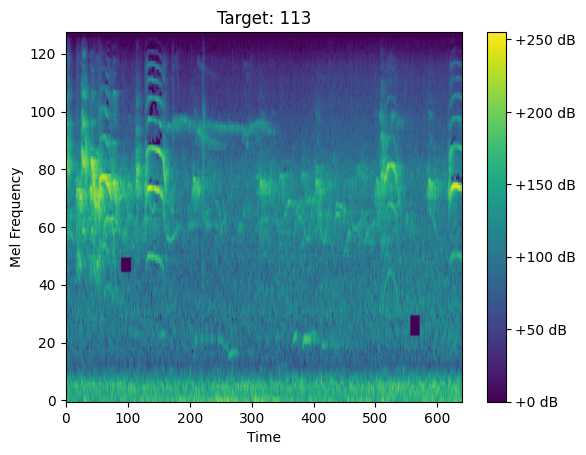

In [16]:
# print a sample spec
res = ds_train[random.randint(0, len(ds_train)-1)]
spec = res['pixel_values']
target = res['labels']

print(f"Filepath: {res['file_name']}")
print(f"Target: {target}")
print(f"Shape of mel spectrogram: {spec.shape}")

# Display the mel spectrogram
plt.imshow(spec[0], aspect='auto', origin='lower')
plt.title(f"Target: {target}")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()

In [17]:
# print train and val loader stats
train_df = ds_train.df
val_df = ds_val.df

def print_label_stats(df, name="Dataset"):
    label_counts = df['label'].value_counts()
    max_count = label_counts.max()
    min_count = label_counts.min()
    mean_count = label_counts.mean()
    std_count = label_counts.std()

    print(f"{name} label statistics:")
    print(f"  Max:  {max_count}")
    print(f"  Min:  {min_count}")
    print(f"  Mean: {mean_count:.2f}")
    print(f"  Std:  {std_count:.2f}")
    print("")

# Print stats for training and validation datasets
print_label_stats(train_df, "Training")
print_label_stats(val_df, "Validation")

Training label statistics:
  Max:  3672
  Min:  3
  Mean: 580.68
  Std:  730.37

Validation label statistics:
  Max:  1183
  Min:  1
  Mean: 153.32
  Std:  189.28



In [3]:
# Define metrics computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate F1 score (weighted for class imbalance)
    f1 = f1_score(labels, predictions, average="weighted")
    
    return {
        "accuracy": accuracy,
        "f1": f1
    }

In [4]:
# Effnet finetune setup
LR = 1e-5
NUM_EPOCHS = 30
BATCH_SIZE = 32
MODEL_NAME = "google/efficientnet-b2"
NUM_CLASSES = 206
DROPOUT_RATE = .3

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = NUM_CLASSES  # Number of output classes
config.hidden_dropout_prob = DROPOUT_RATE  # Dropout for dense layers
config.attention_probs_dropout_prob = DROPOUT_RATE  # Only applicable if the model has attention layers (EfficientNet doesn't)

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_effnet_masking_cutmix",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    learning_rate=LR,
    fp16=torch.cuda.is_available(),  # Enable mixed precision training if available
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    remove_unused_columns=False,
    warmup_steps=500,
    lr_scheduler_type="linear",
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1408]) in the checkpoint and torch.Size([206, 1408]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([206]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Effnet finetune setup
LR = 1e-5
NUM_EPOCHS = 30
BATCH_SIZE = 64
MODEL_NAME = "facebook/regnet-y-008"
NUM_CLASSES = 206
DROPOUT_RATE = .3

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = NUM_CLASSES  # Number of output classes
config.hidden_dropout_prob = DROPOUT_RATE  # Dropout for dense layers
config.attention_probs_dropout_prob = DROPOUT_RATE  # Only applicable if the model has attention layers (EfficientNet doesn't)

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./outputs/results_effnet_masking_cutmix",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    learning_rate=LR,
    fp16=torch.cuda.is_available(),  # Enable mixed precision training if available
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    remove_unused_columns=False,
    warmup_steps=500,
    lr_scheduler_type="linear",
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-008 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([206, 768]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([206]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Create and run trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

/tmp/ipykernel_203323/2240262213.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),


Step,Training Loss,Validation Loss,Accuracy,F1
1000,4.891200,4.664630,0.114052,0.057778
2000,4.551200,3.978187,0.237425,0.160286
3000,4.232500,3.441867,0.317637,0.238476
4000,4.065900,3.103269,0.376609,0.305921
5000,3.900700,2.847886,0.425508,0.362960
6000,3.764300,2.674963,0.458289,0.402611
7000,3.668900,2.533092,0.480178,0.428874
8000,3.608800,2.398000,0.501383,0.456764
9000,3.505700,2.319482,0.521598,0.479794
10000,3.530800,2.217909,0.536350,0.496604


/tmp/ipykernel_203323/2240262213.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
/tmp/ipykernel_203323/2240262213.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
/tmp/ipykernel_203323/2240262213.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
/tmp/ipykernel_203323/2240262213.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone(

KeyboardInterrupt: 